In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [2]:
data_root = "./plates"
print(os.listdir(data_root))

['test', 'train']


In [3]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

print(train_dataset)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

Dataset ImageFolder
    Number of datapoints: 32
    Root location: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
print(len(train_dataloader), len(train_dataset))
print(train_dataloader.dataset.samples)

4 32
[('train\\cleaned\\0001.jpg', 0), ('train\\cleaned\\0002.jpg', 0), ('train\\cleaned\\0003.jpg', 0), ('train\\cleaned\\0004.jpg', 0), ('train\\cleaned\\0005.jpg', 0), ('train\\cleaned\\0007.jpg', 0), ('train\\cleaned\\0008.jpg', 0), ('train\\cleaned\\0009.jpg', 0), ('train\\cleaned\\0010.jpg', 0), ('train\\cleaned\\0011.jpg', 0), ('train\\cleaned\\0013.jpg', 0), ('train\\cleaned\\0014.jpg', 0), ('train\\cleaned\\0015.jpg', 0), ('train\\cleaned\\0016.jpg', 0), ('train\\cleaned\\0017.jpg', 0), ('train\\cleaned\\0019.jpg', 0), ('train\\dirty\\0001.jpg', 1), ('train\\dirty\\0002.jpg', 1), ('train\\dirty\\0003.jpg', 1), ('train\\dirty\\0004.jpg', 1), ('train\\dirty\\0005.jpg', 1), ('train\\dirty\\0007.jpg', 1), ('train\\dirty\\0008.jpg', 1), ('train\\dirty\\0009.jpg', 1), ('train\\dirty\\0010.jpg', 1), ('train\\dirty\\0011.jpg', 1), ('train\\dirty\\0013.jpg', 1), ('train\\dirty\\0014.jpg', 1), ('train\\dirty\\0015.jpg', 1), ('train\\dirty\\0016.jpg', 1), ('train\\dirty\\0017.jpg', 1), (

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [14]:
def show_input(input_tensor, title='', num_batch=0, num_elem_batch=0):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + title)
    plt.show()
    plt.pause(0.001)

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch = next(it)
        num_elem_batch = 0
        for x_item, y_item in zip(X_batch, y_batch):
            show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
            num_elem_batch += 1

# def show_input_all():
#     dataloader = train_dataloader
#     i = 0
#     for X_batch, y_batch in tqdm(dataloader):
#         num_elem_batch = 0
#         for x_item, y_item in zip(X_batch, y_batch):
#             show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
#             num_elem_batch += 1
#         i += 1

#     dataloader = train_dataloader
#     i = 0
#     for X_batch, y_batch in tqdm(dataloader):
#         num_elem_batch = 0
#         for x_item, y_item in zip(X_batch, y_batch):
#             show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
#             num_elem_batch += 1
#         i += 1

In [ ]:
# show_input_all()
show_input_all(train_dataloader)

In [ ]:
show_input_all(val_dataloader)

In [19]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

In [20]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return model

In [21]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(model)
print(device)
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

cuda:0


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=100)

In [65]:
losses = {}
accuracies = {}
# tmp = []
# for elem in train_accuracy_history:
#     # tmp.append(elem.data.cpu().numpy().item())
#     tmp.append(elem.item())
# print(tmp)
losses['train'], accuracies['train'] = train_loss_history, [elem.item() for elem in train_accuracy_history]
# losses['train'], accuracies['train'] = train_loss_history, tmp
losses['val'], accuracies['val'] = val_loss_history, [elem.item() for elem in val_accuracy_history]

[0.375, 0.53125, 0.6875, 0.6875, 0.59375, 0.65625, 0.625, 0.59375, 0.875, 0.78125, 0.6875, 0.84375, 0.75, 0.875, 0.875, 0.84375, 0.875, 0.6875, 0.875, 0.875, 0.78125, 0.84375, 0.90625, 0.8125, 0.8125, 0.84375, 0.75, 0.84375, 0.875, 0.8125, 0.84375, 0.75, 0.8125, 0.78125, 0.78125, 0.8125, 0.84375, 0.8125, 0.8125, 0.8125, 0.71875, 0.8125, 0.6875, 0.8125, 0.75, 0.75, 0.875, 0.84375, 0.875, 0.90625, 0.90625, 0.84375, 0.96875, 0.71875, 0.84375]
[0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.5, 0.625, 0.25, 0.25, 0.25, 0.25, 0.25, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.375, 0.5, 0.375, 0.375, 0.375, 0.25, 0.25, 0.25, 0.25, 0.375, 0.375, 0.25, 0.25, 0.25, 0.375, 0.25, 0.25, 0.25, 0.25, 0.375, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


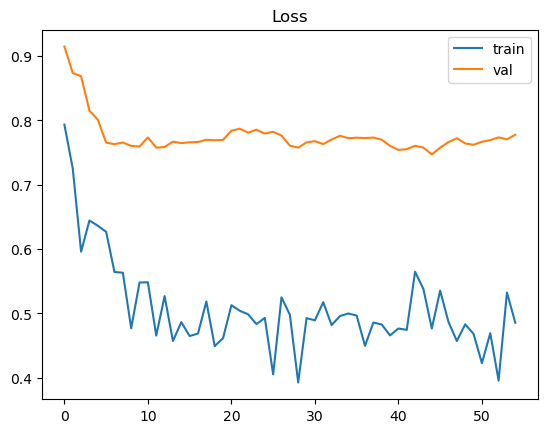

In [66]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss');
# print(losses['val'])
# print(elem.data.cpu().numpy() for elem in accuracies['val'])
# for elem in accuracies['val']:
    # print(elem.data.cpu().numpy())
    # print(elem.data.cpu())
# print(accuracies['val'])
print(accuracies['train'])
print(accuracies['val'])

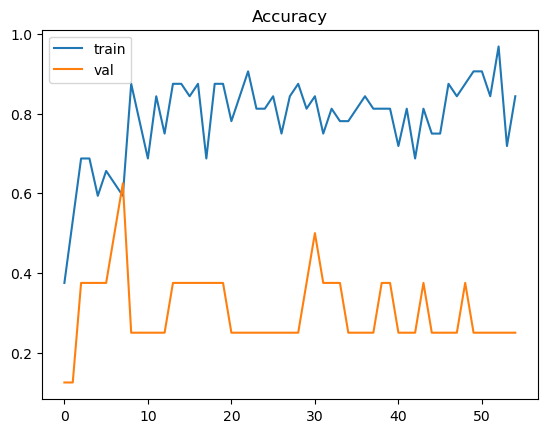

In [67]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy');

In [68]:
test_dir = 'test'

In [69]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [70]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [71]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

100%|██████████| 93/93 [00:10<00:00,  8.92it/s]


In [ ]:
iter = iter(test_dataloader)
for i in range(len(test_dataloader)):
    inputs, labels, paths = next(iter)
    num_elem_batch = 0
    for img, pred in zip(inputs, test_predictions[i]):
        show_input(img, title=str(pred), num_batch=i+1, num_elem_batch=num_elem_batch+1)
        num_elem_batch += 1

test_predictions = np.concatenate(test_predictions)

In [73]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace(test_dir + "\\unknown\\", "")
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [75]:
submission_df.to_csv('submission2.csv')